# UCI regression with outliers

In [2]:
import jax
import optax
import pickle
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
    "OGD": "blueviolet",
    "WLF-OGD": "silver",
}

## Load dataset

In [4]:
uci = datagen.UCIDatasets("./data")

In [5]:
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    print(dataset_name, dataset.shape)

protein-tertiary-structure (45730, 10)
naval-propulsion-plant (11934, 18)
wine-quality-red (1599, 12)
bostonHousing (506, 14)
power-plant (9568, 5)
concrete (1030, 9)
energy (768, 9)
kin8nm (8192, 9)
yacht (308, 7)


In [6]:
dataset_name = "kin8nm"
# dataset_name = "naval-propulsion-plant"
noise_type = "target" # or "covariate"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 100
v_error = 50
seed_init = 314
p_error = 0.10
for i in range(n_runs):
    if noise_type == "target":
        data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].astype(bool)
    elif noise_type == "covariate":
        data = uci.sample_noisy_covariates(dataset_name, p_error=p_error, seed=seed_init + i, v_error=v_error)
        ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    else:
        raise KeyError(f"Noise {noise_type} not available")
        
    X = data["X"]
    y = data["y"]
    
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [7]:
n_samples = y.shape[0]
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T
X_collection.shape

(100, 7373, 8)

## Setup

In [9]:
n_hidden = 20
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [10]:
def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [11]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [12]:
Q = 0.0
observation_covariance = 1.0

In [13]:
key = jax.random.PRNGKey(314)
model = MLP()
def latent_fn(x): return x
measurement_fn = model.apply
params_init = model.init(key, X[:1])

# Run experiments

In [14]:
time_methods = {}
hist_methods = {}
configs = {}

In [15]:
observation_covariance = jnp.eye(1) * 1.0

## Kalman Filter

In [16]:
@jax.jit
def filter_kf(log_lr, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=1e8,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr):
    yhat_pp = filter_kf(log_lr, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [17]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -1.064    | -0.4156   |
| 2         | -0.8058   | -2.057    |
| 3         | -0.3432   | -3.675    |
| 4         | -0.8548   | -1.084    |
| 5         | -0.665    | -0.41     |
| 6         | -0.3314   | -2.846    |
| 7         | -0.3314   | -2.846    |
| 8         | -0.397    | -3.681    |
| 9         | -0.2739   | -3.666    |
| 10        | -0.4053   | -3.656    |
| 11        | -0.3324   | -2.833    |
| 12        | -0.9694   | -0.3951   |
| 13        | -0.2737   | -2.821    |
| 14        | -0.574    | -2.81     |
| 15        | -0.276    | -2.858    |


In [18]:
method = "KF"
log_lr = bo.max["params"]["log_lr"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_kf(log_lr, y, X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


## KF-B

In [19]:
@jax.jit
def filter_kfb(log_lr, alpha, beta, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = rkf.ExtendedKalmanFilterBernoulli(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        n_inner=n_inner
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, alpha, beta, n_inner):
    yhat_pp = filter_kfb(log_lr, alpha, beta, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [20]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0),

        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |   alpha   |   beta    |  log_lr   |  n_inner  |
-------------------------------------------------------------------------
| 2         | -0.01185  | 4.59      | 4.137     | -1.36     | 3.344     |
| 3         | -0.01111  | 4.559     | 1.304     | -1.168    | 3.354     |
| 7         | -0.01102  | 2.853     | 2.399     | -0.6946   | 8.513     |
| 21        | -0.008931 | 2.476     | 0.0       | 0.0       | 5.355     |


In [21]:
method = "KF-B"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_kfb(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


## KF-IW

In [22]:
@jax.jit
def filter_kfiw(log_lr, noise_scaling, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = rkf.ExtendedKalmanFilterInverseWishart(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance,
        n_inner=n_inner,
        noise_scaling=noise_scaling
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, noise_scaling, n_inner):
    yhat_pp = filter_kfiw(log_lr, noise_scaling, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [23]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "noise_scaling": (1e-6, 20),
        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   |  n_inner  | noise_... |
-------------------------------------------------------------


In [24]:
method = "KF-IW"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_kfiw(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


## WLF-IMQ

In [25]:
@jax.jit
def filter_wlfimq(log_lr, soft_threshold, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, soft_threshold):
    yhat_pp = filter_wlfimq(log_lr, soft_threshold, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [26]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "soft_threshold": (1e-6, 20)
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 1         | -0.0171   | -0.4156   | 11.77     |
| 2         | -0.02582  | -3.675    | 15.66     |
| 3         | -0.02774  | -0.41     | 16.55     |
| 4         | -0.01132  | -1.36     | 5.21      |
| 5         | -0.01004  | -0.4412   | 5.215     |
| 6         | -0.0111   | -1.168    | 5.231     |
| 7         | -0.01858  | -4.389    | 7.72      |
| 8         | -0.01089  | -0.7996   | 5.564     |
| 9         | -0.0223   | -4.65     | 12.66     |
| 10        | -0.0196   | -2.076    | 11.62     |
| 11        | -0.02241  | -1.614    | 13.74     |
| 12        | -0.01414  | -2.805    | 6.419     |
| 13        | -0.01585  | -2.147    | 9.597     |
| 14        | -0.03133  | -0.6946   | 16.7      |
| 15        | -0.01883  | -4.471    | 1.208     |
| 16        | -0.02596  | -2.016    | 15.85     |
| 17        | -0.01864  | -3.868    | 10.7      |
| 18        | -0.0183   | -4.32     | 7.445     |


In [27]:
method = "WLF-IMQ"
log_lr = bo.max["params"]["log_lr"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_wlfimq(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.61it/s]


## WLF-MD

In [28]:
@jax.jit
def filter_wlfmd(log_lr, threshold, measurements, covariates):
    lr = jnp.exp(log_lr)
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        threshold=threshold,
    )
    
    init_bel = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, threshold):
    yhat_pp = filter_wlfmd(log_lr, threshold, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [29]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "threshold": (1e-6, 20)
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
| 1         | -0.00926  | -0.4156   | 11.77     |
| 2         | -0.01647  | -3.675    | 15.66     |
| 3         | -0.00902  | -0.41     | 16.55     |
| 4         | -0.01086  | -1.36     | 5.21      |
| 5         | -0.009247 | -0.4412   | 5.215     |
| 6         | -0.01081  | -1.168    | 5.231     |
| 7         | -0.01822  | -4.389    | 7.72      |
| 8         | -0.0104   | -0.7996   | 5.564     |
| 9         | -0.01938  | -4.65     | 12.66     |
| 10        | -0.01184  | -2.076    | 11.62     |
| 11        | -0.01124  | -1.614    | 13.74     |
| 12        | -0.01364  | -2.805    | 6.419     |
| 13        | -0.01194  | -2.147    | 9.597     |
| 14        | -0.01024  | -0.6946   | 16.7      |
| 15        | -0.01852  | -4.471    | 1.208     |
| 16        | -0.01174  | -2.016    | 15.85     |
| 17        | -0.01699  | -3.868    | 10.7      |
| 18        | -0.0181   | -4.32     | 7.445     |


In [30]:
method = "WLF-MD"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_wlfmd(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


## OGD

In [31]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

In [32]:
@jax.jit
def filter_ogd(log_lr, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = replay_sgd.FifoSGD(
        measurement_fn,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=covariates.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )
    
    callback = partial(callback_fn, applyfn=measurement_fn)
    
    init_bel = agent.init_bel(params_init)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, n_inner):
    yhat_pp = filter_ogd(log_lr, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [33]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10),
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 1         | -12.64    | -0.4156   | 6.297     |
| 2         | -1.118    | -3.675    | 8.049     |
| 3         | -10.92    | -0.41     | 8.446     |
| 4         | -3.328    | -1.36     | 3.344     |
| 5         | -8.447    | -0.4412   | 3.347     |
| 6         | -4.078    | -1.168    | 3.354     |
| 7         | -0.4523   | -4.389    | 4.474     |
| 8         | -5.992    | -0.7996   | 3.504     |
| 9         | -0.6104   | -4.65     | 6.698     |
| 10        | -3.213    | -2.076    | 6.231     |
| 11        | -5.957    | -1.614    | 7.184     |
| 12        | -1.049    | -2.805    | 3.888     |
| 13        | -2.586    | -2.147    | 5.319     |
| 14        | -11.88    | -0.6946   | 8.513     |
| 15        | -0.1225   | -4.471    | 1.544     |
| 16        | -4.545    | -2.016    | 8.132     |
| 17        | -0.661    | -3.868    | 5.817     |
| 18        | -0.3692   | -4.32     | 4.35      |


In [34]:
method = "OGD"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_ogd(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.53it/s]


## WLF-OGD

In [35]:
@jax.jit
def filter_wlf_ogd(log_lr, soft_threshold, n_inner, measurements, covariates):
    lr = jnp.exp(log_lr)
    n_inner = n_inner.astype(int)
    
    agent = rkf.FifoSGDIMQ(
        measurement_fn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=covariates.shape[-1],
        dim_output=1,
        soft_threshold=soft_threshold,
        n_inner=n_inner,
    )
    
    callback = partial(callback_fn, applyfn=measurement_fn)
    
    init_bel = agent.init_bel(params_init)
    bel, yhat_pp = agent.scan(init_bel, measurements, covariates, callback_fn=callback)
    
    # out = (agent, bel)
    return yhat_pp.squeeze()


@jax.jit
def opt_step(log_lr, soft_threshold, n_inner):
    yhat_pp = filter_wlf_ogd(log_lr, soft_threshold, n_inner, y, X)
    err = jnp.power(yhat_pp - y, 2)
    err = jnp.median(err)
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [36]:
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-10, 0),
        "soft_threshold": (1e-6, 20),
        "n_inner": (1, 10),
    },
    verbose=2,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  log_lr   |  n_inner  | soft_t... |
-------------------------------------------------------------
| 1         | -0.1343   | -0.8313   | 6.297     | 5.301     |
| 2         | -0.1343   | -2.168    | 9.262     | 16.55     |
| 3         | -0.1294   | -2.72     | 3.344     | 18.24     |
| 4         | -0.01646  | -7.392    | 7.897     | 5.231     |
| 5         | -0.04221  | -8.777    | 4.474     | 16.8      |
| 6         | -0.03219  | -7.218    | 1.629     | 12.66     |
| 7         | -0.05773  | -4.152    | 6.231     | 13.54     |
| 8         | -0.04308  | -3.128    | 4.95      | 6.419     |
| 9         | -0.06273  | -4.294    | 5.319     | 17.22     |
| 10        | -0.03825  | -1.652    | 1.952     | 1.208     |
| 11        | -0.03652  | -4.031    | 8.132     | 4.527     |
| 12        | -0.02441  | -4.648    | 2.225     | 7.445     |
| 13        | -0.03868  | -8.48     | 4.868     | 15.85     |
| 14        | -0.04446  | -5.93     | 2.601     | 18.19     |
| 15    

In [37]:
method = "WLF-OGD"
configs[method] = bo.max["params"]

hist_bel = []
times = []

for yc, Xc in tqdm(zip(y_collection, X_collection), total=n_runs): 
    tinit = time()
    run = filter_wlf_ogd(**bo.max["params"], measurements=y, covariates=X)
    run = jax.block_until_ready(run)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


# Summary

In [38]:
rmedse_df = pd.DataFrame(jax.tree_map(
    lambda x: np.sqrt(np.median(np.power(x - y_collection, 2), 1)),
    hist_methods
))
rmedse_df = rmedse_df.reset_index().melt("index")
rmedse_df = rmedse_df.rename({
    "index": "run",
    "variable": "method",
    "value": "err"
}, axis=1)
rmedse_df.head()

,run,method,err
0,0,KF,0.523152
1,1,KF,0.528580
2,2,KF,0.533558
3,3,KF,0.538459
4,4,KF,0.528723


In [39]:
time_df = pd.DataFrame(time_methods).reset_index().melt("index")
time_df = time_df.rename({
    "index": "run",
    "variable": "method",
    "value": "time"
}, axis=1)

time_df.head()

,run,method,time
0,0,KF,0.336941
1,1,KF,0.111719
2,2,KF,0.115884
3,3,KF,0.116028
4,4,KF,0.111584


In [40]:
df = rmedse_df.merge(time_df, on=["method", "run"]).query("run > 0")

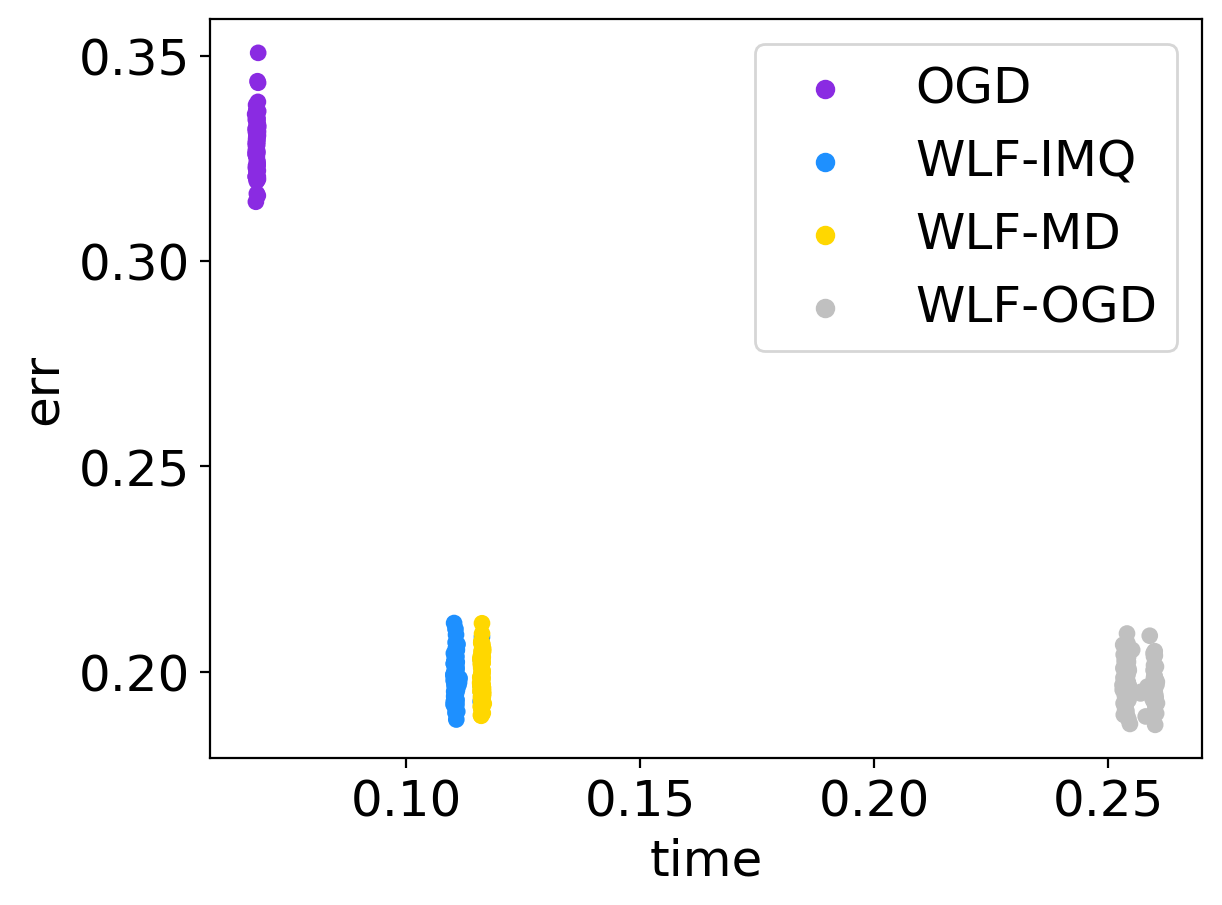

In [41]:
sns.scatterplot(
    x="time",
    y="err",
    hue="method",
    data=df.query("~method.str.startswith('KF')"),
    palette=cmap,
    linewidth=0.0,
)
# plt.yscale("log")
# plt.xscale("log")
plt.legend(bbox_to_anchor=(1,1))

## Store data

In [44]:
print(df.groupby("method").median().drop("run", axis=1))

              err      time
method                     
KF       0.531340  0.111702
KF-B     0.195851  0.807175
KF-IW    0.198982  0.714663
OGD      0.329098  0.068066
WLF-IMQ  0.197946  0.110578
WLF-MD   0.196950  0.116155
WLF-OGD  0.195841  0.254243


In [45]:
df.groupby("method")["time"].mean()

method
KF         0.112440
KF-B       0.807224
KF-IW      0.715028
OGD        0.068058
WLF-IMQ    0.110868
WLF-MD     0.116136
WLF-OGD    0.256077
Name: time, dtype: float64

In [42]:
data = {
    "datasets": {
        "X": np.array(X_collection),
        "y": np.array(y_collection),
    },
    "time": {k: np.array(v) for k, v in time_methods.items()},
    "posterior-states": hist_methods,
    "config": configs,
    "dataset-name": dataset_name,
    "p-error": p_error,
}

In [195]:
p_error_str = format(p_error * 100, "0.0f")
filename = f"{dataset_name}-{noise_type}-p-error{p_error_str}.pkl"
print(f"Storing in {filename}")
with open(filename, "wb") as f:
    pickle.dump(data, f)

Storing in naval-propulsion-plant-target-p-error10.pkl
